In [57]:
import pandas as pd
import numpy as np
import tensorflow as tf  # 导入TensorFlow库，用于构建和训练机器学习模型
import shap # 导入SHAP库，用于解释模型预测
import seaborn as sns
import matplotlib.font_manager as fm
import csv
import os
import chardet

from multiprocessing.spawn import import_main_path
from sklearn.preprocessing import MinMaxScaler
shap.initjs()   # 初始化SHAP的JavaScript环境
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape  # 导入Input和Dense，用于构建网络层
from tensorflow.keras import regularizers  # 导入regularizers，用于添加正则化
from tensorflow.keras.callbacks import EarlyStopping  # 导入EarlyStopping，用于提前停止训练
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.losses import MeanSquaredError  
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
# mpl.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
# plt.rcParams['axes.unicode_minus'] = False # 设置坐标轴负号
# plt.rcParams['font.size'] = 23  # 设置字体大小
# plt.rcParams['figure.dpi'] = 3000  # 设置图像分辨率

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
 
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

### 数据预处理

In [48]:
# 加载 CSV 文件
data = pd.read_csv("../data/water/整理好的csv/杭州202101-202112/东苕溪202101-202112.csv", encoding="utf-8").dropna()  # 读取CSV文件并删除缺失值
# data['Timestamp'] = pd.to_datetime(data['监测时间'], format = '%Y-%m-%d %H:%M')
# data.drop(['省份','城市','河流','流域'],axis = 1,inplace= True)  # 删除不需要的列
data.drop(['省份','城市','河流','流域','断面名称','监测时间','水质类别'],axis = 1,inplace= True)  # 删除不需要的列
# data = data.reset_index(drop=True) # 重置索引
# data = data[]
# data = data.T
# data = data.iloc[3:]
# 将非数值数据转换为 NaN
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 处理缺失值
data.fillna(0, inplace=True)  # 用 0 填充缺失值，或者你可以选择其他合适的值

# 显示数据类型
print(data.dtypes)


水温      float64
pH      float64
溶解氧     float64
高锰酸钾    float64
氨氮      float64
总磷      float64
总氮      float64
电导率     float64
浊度      float64
dtype: object


In [49]:
# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 删除重复行
data.drop_duplicates(inplace=True)

# 显示前10行数据
print(data.head())

# 查看数据的基本信息
data.info()
# data.head()

    水温    pH    溶解氧  高锰酸钾     氨氮     总磷    总氮    电导率    浊度
0  8.4  8.08  10.91  1.82  0.102  0.051  1.87  415.8  20.7
1  8.0  8.04  10.73  1.74  0.109  0.050  1.69  418.2  18.2
2  7.8  8.02  10.59  1.65  0.119  0.048  2.40  418.6  15.9
3  8.3  8.05  10.90  1.74  0.117  0.044  2.10  418.8  13.9
4  8.9  8.07  11.00  1.59  0.121  0.046  2.05  418.8  13.2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2554 entries, 0 to 2553
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   水温      2554 non-null   float64
 1   pH      2554 non-null   float64
 2   溶解氧     2554 non-null   float64
 3   高锰酸钾    2554 non-null   float64
 4   氨氮      2554 non-null   float64
 5   总磷      2554 non-null   float64
 6   总氮      2554 non-null   float64
 7   电导率     2554 non-null   float64
 8   浊度      2554 non-null   float64
dtypes: float64(9)
memory usage: 179.7 KB


C:\Users\admin\AppData\Local\Temp\ipykernel_2660\341957695.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [50]:
# # 将日期转换为日期时间格式
# data['监测时间'] = pd.to_datetime(data['监测时间'], format='%Y/%m/%d %H:%M')
# # data = data[data['hour'].between(0, 23)]  # 确保小时在0到23之间

# 统计每列中空值的数量
data.isnull().sum()

水温      0
pH      0
溶解氧     0
高锰酸钾    0
氨氮      0
总磷      0
总氮      0
电导率     0
浊度      0
dtype: int64

In [51]:
# 查找系统中的中文字体
zh_fonts = [f.name for f in fm.fontManager.ttflist if 'CN' in f.name or 'Kai' in f.name or 'Hei' in f.name]

# 如果找到了可用的中文字体，使用第一个找到的
if zh_fonts:
    plt.rcParams['font.sans-serif'] = [zh_fonts[1]]  # 自动选择系统中的可用中文字体
else:
    print("未找到中文字体，确保系统中安装了中文字体。")

plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

In [52]:
# 特征标准化
data_norm = (data - data.mean()) / data.std()  # 标准化数据
# data_norm = data_norm.iloc[:, 1:]
data_norm = data_norm.astype('float32')  # 转换数据类型
start_sclice=540  # 定义切片起始位置
# 构建自编码器模型
data_norm_train = pd.concat([data_norm[:start_sclice],data_norm[start_sclice+300:]],ignore_index=True) # 训练数据
data_norm_test = data_norm[start_sclice:start_sclice+300]  # 测试数据
# data_norm_train,data_norm_test = train_test_split(data_norm,test_size=0.2)

### AE

In [53]:
# input_dim = data_norm.shape[1]  # 输入维度
# encoding_dim = 5  # 编码维度
# # 构建编码器和解码器
# input_layer = tf.keras.layers.Input(shape=(input_dim,)) # 创建输入层，接收形状为 (input_dim,) 的输入数据
# # 创建第一个全连接层作为编码器的一部分，使用 8 个神经元，ReLU 激活函数，并添加 L1 正则化项（权重衰减）来防止过拟合
# encoder = Dense(8, activation="relu",
#                 activity_regularizer=regularizers.l1(10e-7))(input_layer)

# encoder = Dense(5, activation="relu",
#                 kernel_regularizer=regularizers.l2(10e-7))(encoder)

# encoder = Dense(3, activation='relu',
#                 kernel_regularizer=regularizers.l2(10e-7))(encoder)
# # 创建第一个全连接层作为解码器的一部分，使用 5 个神经元，ReLU 激活函数，并添加 L2 正则化项来防止过拟合
# decoder = Dense(5, activation='relu',
#                 kernel_regularizer=regularizers.l2(10e-7))(encoder)
# decoder = Dense(8, activation='relu',
#                 kernel_regularizer=regularizers.l2(10e-7))(decoder)
# # 创建输出层，使用与输入层相同数量的神经元，Sigmoid 激活函数，并添加 L2 正则化项来防止过拟合
# # Sigmoid 激活函数用于将输出值限制在 0 和 1 之间，适用于将输出值解释为概率
# decoder = Dense(input_dim, activation='sigmoid',
#                 kernel_regularizer=regularizers.l2(10e-7))(decoder)

# autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)  # 构建模型
# autoencoder.compile(
#     optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # 编译模型
# # 训练自编码器模型
# earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 定义提前停止的参数
# history = autoencoder.fit(data_norm_train,data_norm_train, epochs=50, batch_size=11, shuffle=True, validation_data=(data_norm_train, data_norm_train), callbacks=[earlystopper])
# # 使用自编码器模型对数据进行预测
# reconstructed_data = autoencoder.predict(data_norm_test)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.1894 - mse: 1.1893 - val_loss: 1.0136 - val_mse: 1.0135
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9758 - mse: 0.9757 - val_loss: 0.8755 - val_mse: 0.8754
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8496 - mse: 0.8495 - val_loss: 0.8220 - val_mse: 0.8219
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8178 - mse: 0.8177 - val_loss: 0.7855 - val_mse: 0.7854
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7380 - mse: 0.7379 - val_loss: 0.7717 - val_mse: 0.7715
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7094 - mse: 0.7093 - val_loss: 0.7607 - val_mse: 0.7606
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7318 - mse: 0.7316 - val_loss: 0.7551 - val_mse: 0.7549
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7471 - mse: 0.7469 - val_loss: 0.7525 - val_mse: 0.7524
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

### VAE

In [61]:
def kl_divergence(z_mean, z_log_var):  
    # 计算KL散度  
    # z_mean 和 z_log_var 是编码器的输出，分别代表潜在空间的均值和对数方差  
    # 我们假设先验分布为标准正态分布（均值为0，方差为1）  
      
    # 计算方差  
    z_var = tf.exp(z_log_var)  
      
    # 计算KL散度的每个分量  
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var, axis=-1)  
      
    # 返回KL散度的平均值（如果需要的话）  
    return tf.reduce_mean(kl_loss)  
  
input_dim = data_norm.shape[1]  # 输入维度  
latent_dim = 5  # 潜在空间维度  

# 编码器  
inputs = Input(shape=(input_dim,))  
x = Dense(128, activation='relu')(inputs)  
x = Dense(64, activation='relu')(x)  
z_mean = Dense(latent_dim, name='z_mean')(x)  
z_log_var = Dense(latent_dim, name='z_log_var')(x)  

# 重参数技巧（Reparameterization Trick）  
def sampling(args):  
    z_mean, z_log_var = args  
    batch = K.shape(z_mean)[0]  
    dim = K.shape(z_mean)[1]  
    epsilon = K.random_normal(shape=(batch, dim))  
    return z_mean + K.exp(0.5 * z_log_var) * epsilon  

# 使用重参数技巧从潜在空间采样  
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  
  
# 解码器  
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')  
x = Dense(64, activation='relu')(latent_inputs)  
x = Dense(128, activation='relu')(x)  
outputs = Dense(input_dim, activation='sigmoid')(x)  
  
# 实例化编码器和解码器模型  
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')  
decoder = Model(latent_inputs, outputs, name='decoder')  

# VAE模型，将编码器输出作为解码器的输入  
outputs = decoder(encoder(inputs)[2])  
vae = Model(inputs, outputs, name='vae') 

# VAE损失函数
def vae_loss(z_mean, z_log_var):  
    # 注意：y_true 在这里实际上没有被使用，但它是 Keras 损失函数的必需参数 
    reconstruction_loss = MeanSquaredError()(z_mean, z_log_var)  # 直接使用 MeanSquaredError
    kl_loss = kl_divergence(z_mean, z_log_var) 
    return K.mean(reconstruction_loss + kl_loss)  

# 编译VAE模型，使用自定义损失函数  
vae.compile(optimizer='adam', loss=vae_loss) 
  
# 训练VAE  
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)  
history = vae.fit(data_norm_train, data_norm_train, epochs=50, batch_size=11, shuffle=True,  
                  validation_data=(data_norm_train, data_norm_train), callbacks=[earlystopper])  
  
# 使用VAE模型对数据进行预测  
reconstructed_data = vae.predict(data_norm_test)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 6.2668 - val_loss: 5.7715
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6969 - val_loss: 5.7320
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5694 - val_loss: 5.7174
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.3796 - val_loss: 5.7146
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.9325 - val_loss: 5.7107
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5625 - val_loss: 5.7089
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5762 - val_loss: 5.6965
Epoch 8/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0369 - val_loss: 5.6894
Epoch 9/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4011 - val_loss: 5.6885
Epoch 10/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7711 - val_loss: 5.6881
Epoch 11/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3143 - val_loss: 5.6917
Epoch 12/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

#### VAE-1（水温）

In [78]:
# # 提取'水温'数据  
# temp_data = data_norm.iloc[:, 0]  # 假设'水温'是第一个参数，使用iloc来访问第一列的所有行  
  
# # 转换为适合模型输入的格式  
# temp_data = temp_data.values.reshape(-1, 1)  # 假设temp_data已经是归一化后的数据  
temp_data_train = data_norm_train.iloc[:, 0].values.reshape(-1, 1)
  
# 编码器和解码器的定义（与上面类似，但仅针对一个参数）  
input_dim = 1  # '水温'的维度  
latent_dim = 2  # 潜在空间维度，可以根据需要调整  
  
# 编码器  
inputs = Input(shape=(input_dim,))  
x = Dense(128, activation='relu')(inputs)  
x = Dense(64, activation='relu')(x)  
z_mean1 = Dense(latent_dim, name='z_mean1')(x)  
z_log_var1 = Dense(latent_dim, name='z_log_var1')(x)  

# 重参数技巧（Reparameterization Trick）  
def sampling(args):  
    z_mean1, z_log_var1 = args  
    batch = K.shape(z_mean1)[0]  
    dim = K.shape(z_mean1)[1]  
    epsilon = K.random_normal(shape=(batch, dim))  
    return z_mean1 + K.exp(0.5 * z_log_var1) * epsilon  

# 使用重参数技巧从潜在空间采样  
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean1, z_log_var1])  
  
# 解码器  
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')  
x = Dense(64, activation='relu')(latent_inputs)  
x = Dense(128, activation='relu')(x)  
outputs = Dense(input_dim, activation='sigmoid')(x)  
  
# 实例化模型  
encoder = Model(inputs, [z_mean1, z_log_var1, z], name='encoder_temp')  
decoder = Model(latent_inputs, outputs, name='decoder_temp')  
vae1 = Model(inputs, decoder(encoder(inputs)[2]), name='vae_temp')  
  
# 编译模型  
def vae_loss(x, x_decoded):  
    reconstruction_loss = MeanSquaredError()(x, x_decoded)  
    kl_loss = kl_divergence(z_mean1, z_log_var1)  
    return K.mean(reconstruction_loss + kl_loss)  
  
vae1.compile(optimizer='adam', loss=vae_loss, metrics=['mse'])  
  
# 训练VAE 
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)  
history = vae1.fit(temp_data_train, temp_data_train, epochs=50, batch_size=11, shuffle=True,  
                  validation_data=(temp_data_train, temp_data_train), callbacks=[earlystopper])  

# 使用VAE模型对数据进行预测  
# reconstructed_data = vae1.predict(data_norm_test)
temp_test_data = data_norm_test.iloc[:, 0].values.reshape(-1, 1)  
reconstructed_data = vae1.predict(temp_test_data)  

# 异常检测  
def detect_anomalies(data, model, threshold=0.1):  
    reconstructed = model.predict(data)  
    mse = MeanSquaredError()(data, reconstructed)  
    anomalies = mse > threshold  
    return anomalies  
  
# 使用模型检测异常  
anomalies = detect_anomalies(temp_data_train, vae1, threshold=0.05)  # 阈值根据具体情况调整

Epoch 1/50


ValueError: Tried to convert 'x' to a tensor and failed. Error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


### SHAP

  0%|          | 0/9 [00:00<?, ?it/s]

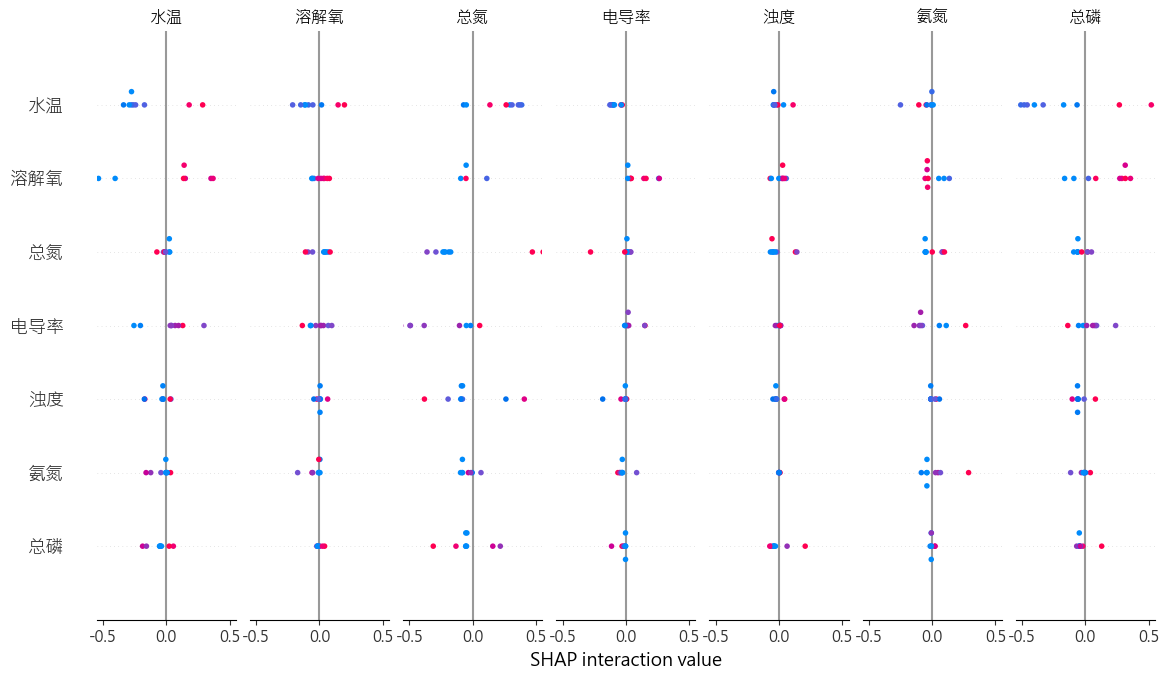

[ 45  57  74 111 112 113 114 272 278]


In [28]:
# 计算重构误差
MSE = np.mean(np.power(data_norm_test - reconstructed_data, 2), axis=1)
# 使用SHAP库计算SHAP值
background_set = shap.sample(data_norm,100) # 从数据中采样作为背景集
explainer = shap.KernelExplainer(autoencoder,background_set,n_jobs = -1)    # 创建解释器
threshold = np.percentile(MSE, 97)  # 定义异常阈值
anomalies = np.where(MSE > threshold)[0]  # 找到异常数据的索引
need2explained = data_norm.iloc[[start_sclice + i for i in anomalies]]  # 获取异常数据
shap_values = explainer.shap_values(need2explained)
# 可视化SHAP值
shap.summary_plot(shap_values, need2explained)
nshap_values = np.array(shap_values)
# 结合SHAP值和重构误差来检测异常值
print(anomalies)

In [62]:
data.iloc[[start_sclice + i for i in anomalies]]


,水温,pH,溶解氧,高锰酸钾,氨氮,总磷,总氮,电导率,浊度
585,16.42,7.86,8.056,0.250,0.0250,0.0050,0.358,379.7,7.2
597,16.42,6.72,8.924,2.731,0.0928,0.0556,3.593,377.1,22.1
614,17.81,7.08,4.524,2.091,0.2321,0.0775,3.533,449.5,11.3
651,19.18,7.37,7.461,6.397,0.7692,0.0050,0.241,367.3,12.2
652,19.25,7.74,9.469,0.250,0.0250,0.0050,0.217,361.3,10.2
653,18.97,7.64,8.463,0.250,0.0250,0.0050,0.212,369.1,9.8
654,18.77,7.50,7.457,0.250,0.0250,0.0050,0.212,371.6,9.0
812,27.82,7.64,3.039,4.111,0.4100,0.0968,1.336,328.7,13.5
818,25.88,7.50,2.977,4.564,0.3000,0.1254,1.549,339.7,30.1


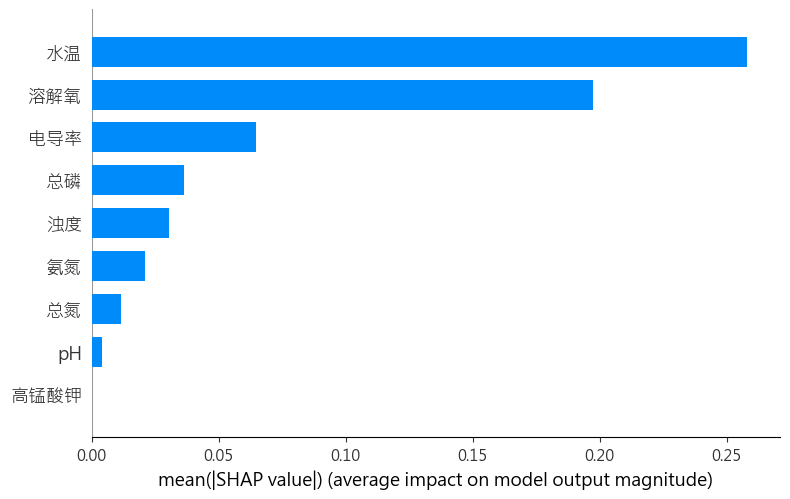

In [63]:
shap.summary_plot(nshap_values[:,0,:],need2explained,plot_type='bar')

In [67]:
# 将异常数据保存到Excel文件
ad_result =data.iloc[[start_sclice + i for i in anomalies]]
ad_result.to_excel('test1.xlsx',sheet_name='Sheet1',index=False)

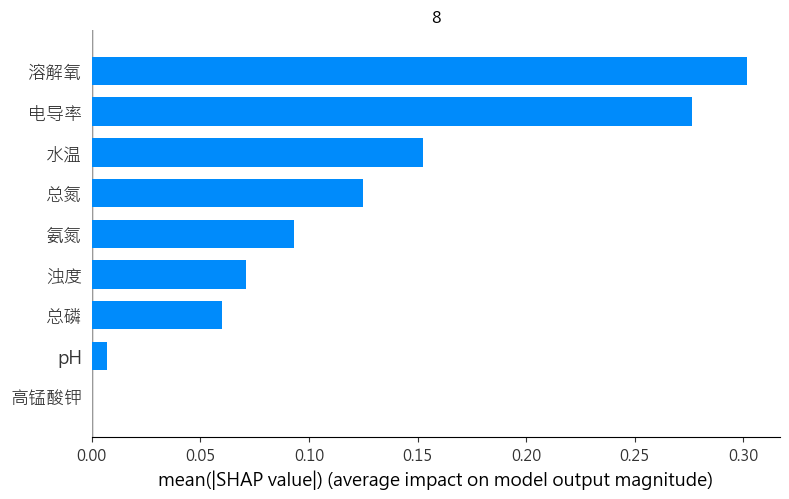

In [65]:
for i in range(8):
    plt.title(f"{i+1}")
    # shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value",auto_size_plot=None)
    shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value")
    plt.savefig(f'image_{i}.svg',bbox_inches='tight')

In [13]:
# images = []
# for i in range(8):
#     img = plt.imread(f"image_{i}.svg")
#     images.append(img)
# # 定义画布和子图
# fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(1,2))
# plt.subplots_adjust(wspace=0.001,hspace=0.001)
# # 在子图中画出每张图片
# for i, ax in enumerate(axs.flat):
#     if i < len(images):
#         ax.imshow(images[i])
#         # ax.text(0.5, -0.1, f"{i+1}", transform=ax.transAxes,
#         #         fontsize=12, ha='center')
#     ax.axis('off')
# plt.tight_layout
# plt.savefig("most_8.svg",format="svg")
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(history.history['loss'], 'b', label='训练曲线', linewidth=3)
# ax.plot(history.history['val_loss'], 'r', label='测试曲线', linewidth=3)
# # ax.set_title('Model loss', fontsize=16)
# ax.set_ylabel('损失率',fontsize=14)
# ax.set_xlabel('迭代次数'fontsize=14)
# ax.legend(loc='upper right',fontsize=12)
# plt.savefig(r'F:\loss.png')
# plt.show()
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()